In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import eigh
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
from pyspark import SparkContext
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999999',
                 grid_width=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hide_labels: axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

def create_2D_gaussian(mn, variance, cov, n):
    """Randomly sample points from a two-dimensional Gaussian distribution"""
    np.random.seed(142)
    return np.random.multivariate_normal(np.array([mn, mn]), np.array([[variance, cov], [cov, variance]]), n)

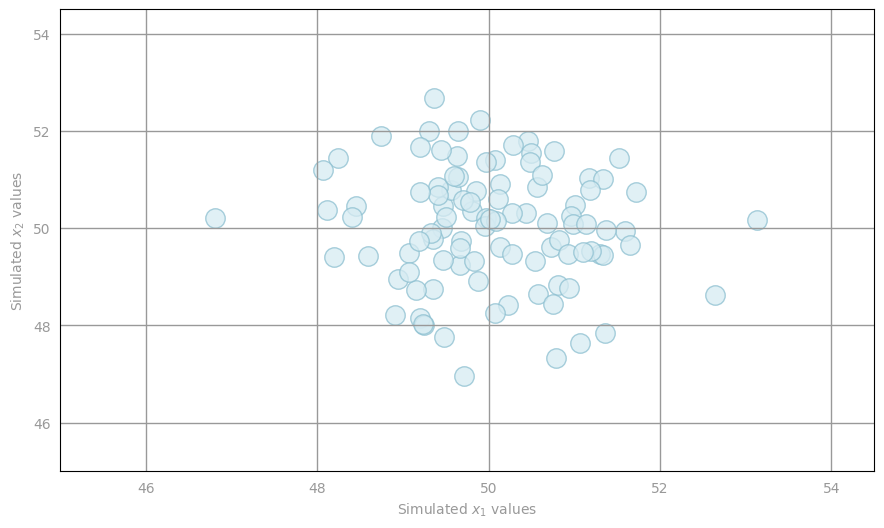

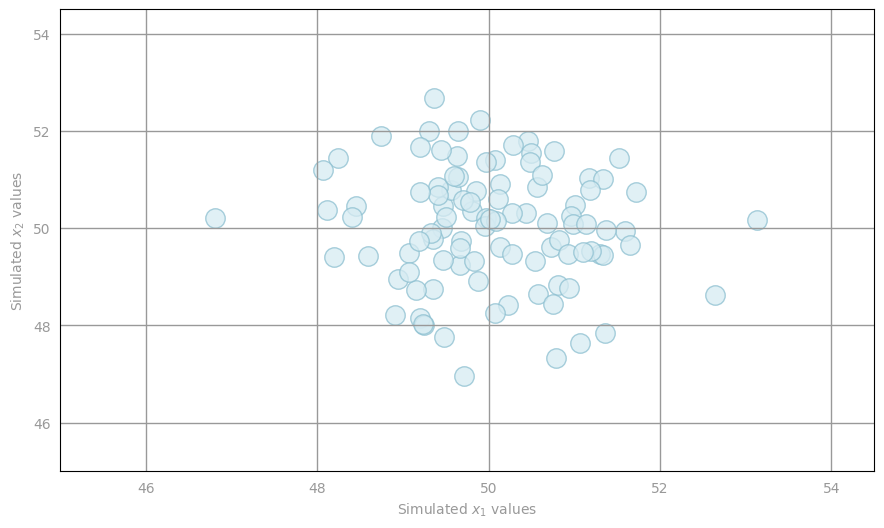

In [3]:
data_random = create_2D_gaussian(mn=50, variance=1, cov=0, n=100)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45, 54.5), ax.set_ylim(45, 54.5)
plt.scatter(data_random[:,0], data_random[:,1], s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
display(fig)

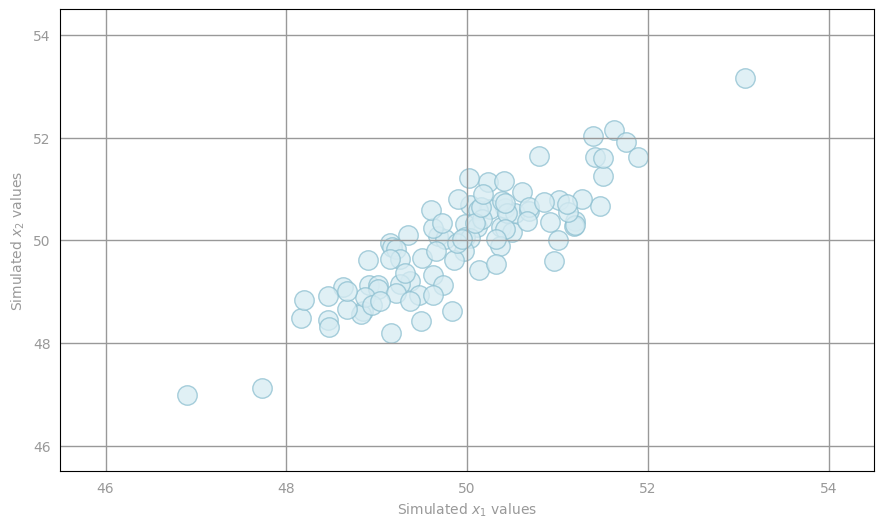

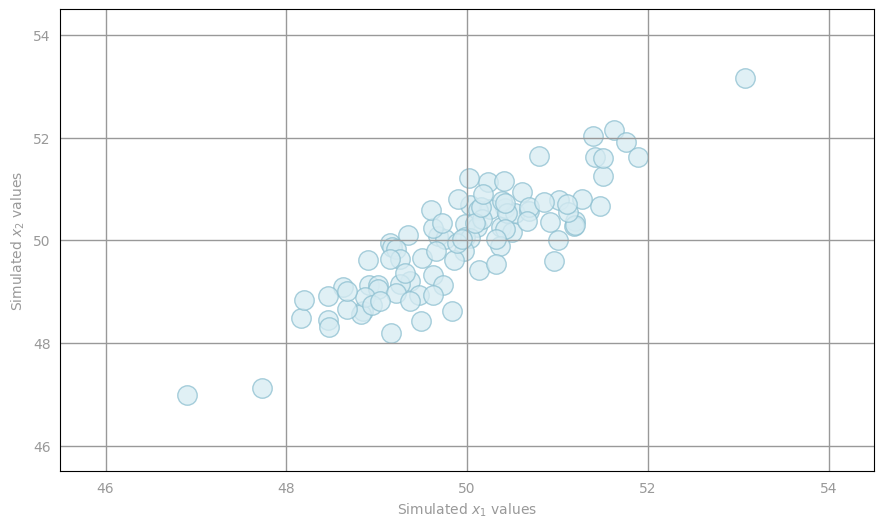

In [4]:
data_correlated = create_2D_gaussian(mn=50, variance=1, cov=.9, n=100)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.scatter(data_correlated[:,0], data_correlated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
display(fig)

In [5]:
sc = SparkContext("local", "SimpleApp")
correlated_data = sc.parallelize(data_correlated)

mean_correlated = correlated_data.mean()
correlated_data_zero_mean = correlated_data.map(lambda x: x-mean_correlated)

print(mean_correlated)
print(correlated_data.take(1))
print(correlated_data_zero_mean.take(1))

[49.95739037 49.97180477]
[array([49.6717712 , 50.07531969])]
[array([-0.28561917,  0.10351492])]


In [6]:
num_data_points = correlated_data_zero_mean.count()
print(num_data_points)
correlated_cov = correlated_data_zero_mean.map(lambda x: np.outer(x, x)).sum() / num_data_points
print(correlated_cov)

100
[[0.99558386 0.90148989]
 [0.90148989 1.08607497]]


In [7]:
def estimate_covariance(data):
    """Compute the covariance matrix for a given rdd.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        data (RDD of np.ndarray):  An `RDD` consisting of NumPy arrays.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input `RDD`.
    """
    data_mean = data.mean()
    corr_cov_data_mean_zero = data.map(lambda x: x-data_mean)
    num_data_pts = corr_cov_data_mean_zero.count()
    return corr_cov_data_mean_zero.map(lambda x: np.outer(x, x)).sum()/num_data_pts

correlated_cov_auto= estimate_covariance(correlated_data)
print(correlated_cov_auto)

[[0.99558386 0.90148989]
 [0.90148989 1.08607497]]


In [8]:
eig_vals, eig_vecs = np.linalg.eigh(correlated_cov_auto)
print('eigenvalues: {0}'.format(eig_vals))
print('\neigenvectors: \n{0}'.format(eig_vecs))

inds = np.argsort(eig_vals)[::-1]
top_component = eig_vecs[:, inds[0]]
print('\ntop principal component: {0}'.format(top_component))

eigenvalues: [0.13820481 1.94345403]

eigenvectors: 
[[-0.72461254  0.68915649]
 [ 0.68915649  0.72461254]]

top principal component: [0.68915649 0.72461254]


In [9]:
correlated_data_scores = correlated_data.map(lambda x: np.dot(x, top_component))
print('one-dimensional data (first three):\n{0}'.format(np.asarray(correlated_data_scores.take(3))))

one-dimensional data (first three):
[70.51682806 69.30622356 71.13588168]


In [10]:
def pca(data, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        data (RDD of np.ndarray): An `RDD` consisting of NumPy arrays.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
            scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
            rows equals the length of the arrays in the input `RDD` and the number of columns equals
            `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
            of length `k`.  Eigenvalues is an array of length d (the number of features).
    """
    correlated_cov_auto = estimate_covariance(data)
    eig_vals, eig_vecs = np.linalg.eigh(correlated_cov_auto)
    inds = np.argsort(eig_vals)[::-1]
    top_k_components = eig_vecs[:, inds[:k]] # size (len(array), k)
    correlated_data_scores = data.map(lambda x: np.dot(x, top_k_components))

    return (top_k_components, correlated_data_scores, eig_vals[::-1])

top_components_correlated, correlated_data_scores_auto, eigenvalues_correlated = pca(correlated_data, k=2)

print('top_components_correlated: \n{0}'.format(top_components_correlated))
print('\ncorrelated_data_scores_auto (first three): \n{0}'
       .format('\n'.join(map(str, correlated_data_scores_auto.take(3)))))
print('\neigenvalues_correlated: \n{0}'.format(eigenvalues_correlated))

pca_test_data = sc.parallelize([np.arange(x, x + 4) for x in np.arange(0, 20, 4)])
components_test, test_scores, eigenvalues_test = pca(pca_test_data, 3)

print('\npca_test_data: \n{0}'.format(np.array(pca_test_data.collect())))
print('\ncomponents_test: \n{0}'.format(components_test))
print('\ntest_scores (first three): \n{0}'.format('\n'.join(map(str, test_scores.take(3)))))
print('\neigenvalues_test: \n{0}'.format(eigenvalues_test))

top_components_correlated: 
[[ 0.68915649 -0.72461254]
 [ 0.72461254  0.68915649]]

correlated_data_scores_auto (first three): 
[70.51682806 -1.48305648]
[69.30622356 -1.5888655 ]
[71.13588168 -1.86710679]

eigenvalues_correlated: 
[1.94345403 0.13820481]

pca_test_data: 
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]

components_test: 
[[ 5.00000000e-01 -7.41676339e-18 -3.43150291e-01]
 [ 5.00000000e-01 -2.25877598e-16 -6.35281904e-01]
 [ 5.00000000e-01 -7.07106781e-01  4.89216098e-01]
 [ 5.00000000e-01  7.07106781e-01  4.89216098e-01]]

test_scores (first three): 
[3.         0.70710678 1.81079858]
[11.          0.70710678  1.81079858]
[19.          0.70710678  1.81079858]

eigenvalues_test: 
[ 1.28000000e+02 -3.94430453e-31 -1.09584308e-14 -3.16741334e-14]


In [11]:
random_data_rdd = sc.parallelize(data_random)

top_components_random, random_data_scores_auto, eigenvalues_random = pca(random_data_rdd, k=2)
print('top_components_random: \n{0}'.format(top_components_random))
print('\nrandom_data_scores_auto (first three): \n{0}'.format('\n'.join(map(str, random_data_scores_auto.take(3)))))
print('\neigenvalues_random: \n{0}'.format(eigenvalues_random))

top_components_random: 
[[-0.2522559  -0.96766056]
 [ 0.96766056 -0.2522559 ]]

random_data_scores_auto (first three): 
[ 36.61068572 -61.3489929 ]
[ 35.97314295 -62.08813671]
[ 35.59836628 -60.61390415]

eigenvalues_random: 
[1.4204546  0.99521397]


In [12]:
def project_points_and_get_lines(data, components, x_range):
    """Project original data onto first component and get line details for top two components."""
    top_component = components[:, 0]
    slope1, slope2 = components[1, :2] / components[0, :2]

    means = data.mean()[:2]
    demeaned = data.map(lambda v: v - means)
    projected = demeaned.map(lambda v: (v.dot(top_component) /
                                        top_component.dot(top_component)) * top_component)
    remeaned = projected.map(lambda v: v + means)
    x1,x2 = zip(*remeaned.collect())

    line_start_P1_X1, line_start_P1_X2 = means - np.asarray([x_range, x_range * slope1])
    line_end_P1_X1, line_end_P1_X2 = means + np.asarray([x_range, x_range * slope1])
    line_start_P2_X1, line_start_P2_X2 = means - np.asarray([x_range, x_range * slope2])
    line_end_P2_X1, line_end_P2_X2 = means + np.asarray([x_range, x_range * slope2])

    return ((x1, x2), ([line_start_P1_X1, line_end_P1_X1], [line_start_P1_X2, line_end_P1_X2]),
            ([line_start_P2_X1, line_end_P2_X1], [line_start_P2_X2, line_end_P2_X2]))

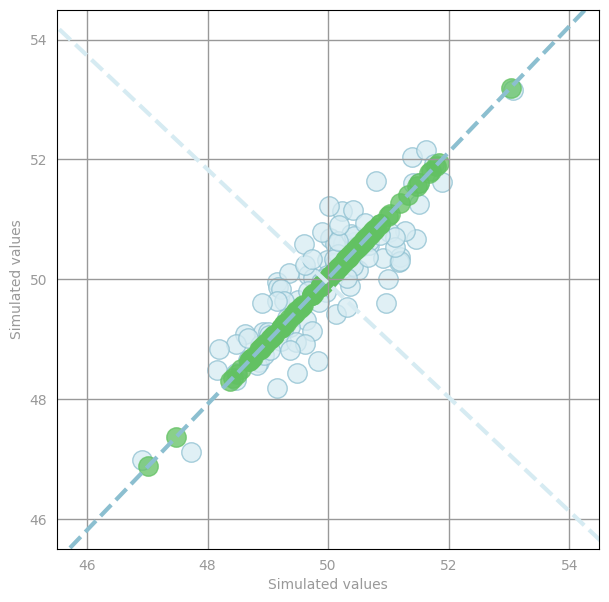

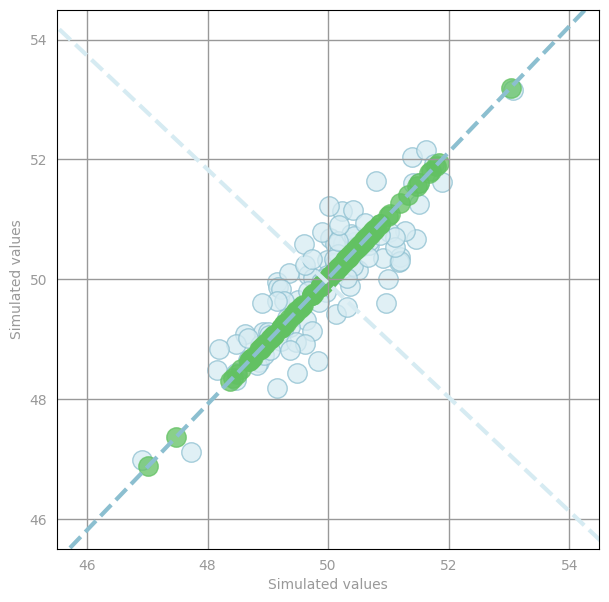

In [13]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    project_points_and_get_lines(correlated_data, top_components_correlated, 5)

fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated values'), ax.set_ylabel(r'Simulated values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
plt.scatter(data_correlated[:,0], data_correlated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', alpha=.75)
display(fig)

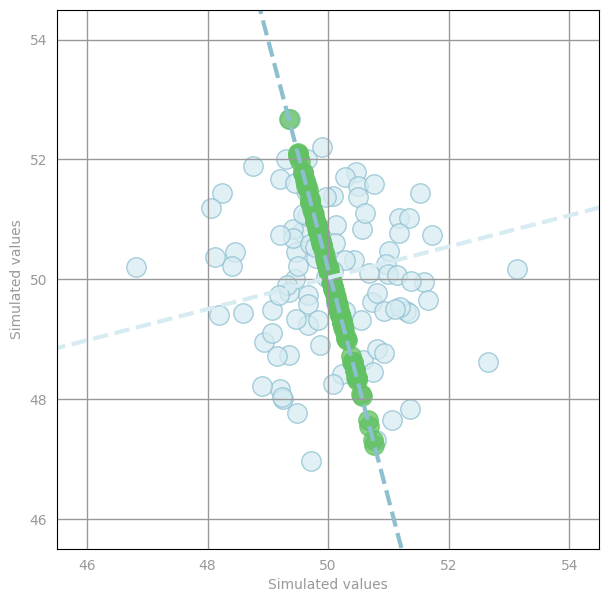

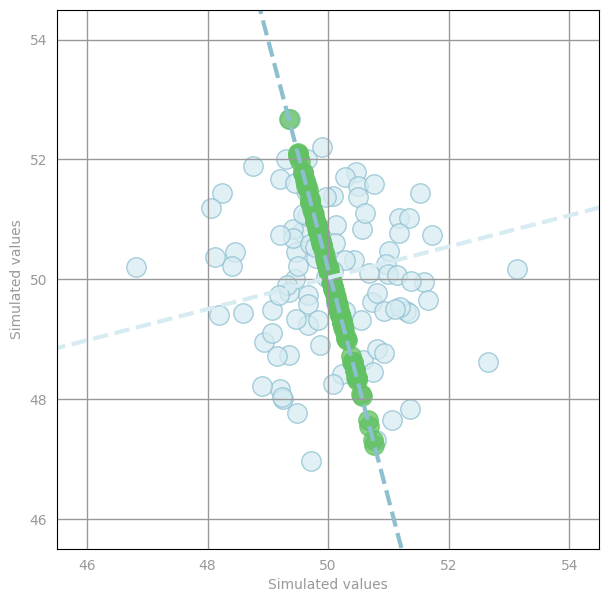

In [14]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    project_points_and_get_lines(random_data_rdd, top_components_random, 5)

fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated values'), ax.set_ylabel(r'Simulated values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
plt.scatter(data_random[:,0], data_random[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', alpha=.75)
display(fig)

<ipython-input-15-94572eba14e1>:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_threeD = np.random.multivariate_normal(mu, c, m)
<ipython-input-15-94572eba14e1>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Blues")


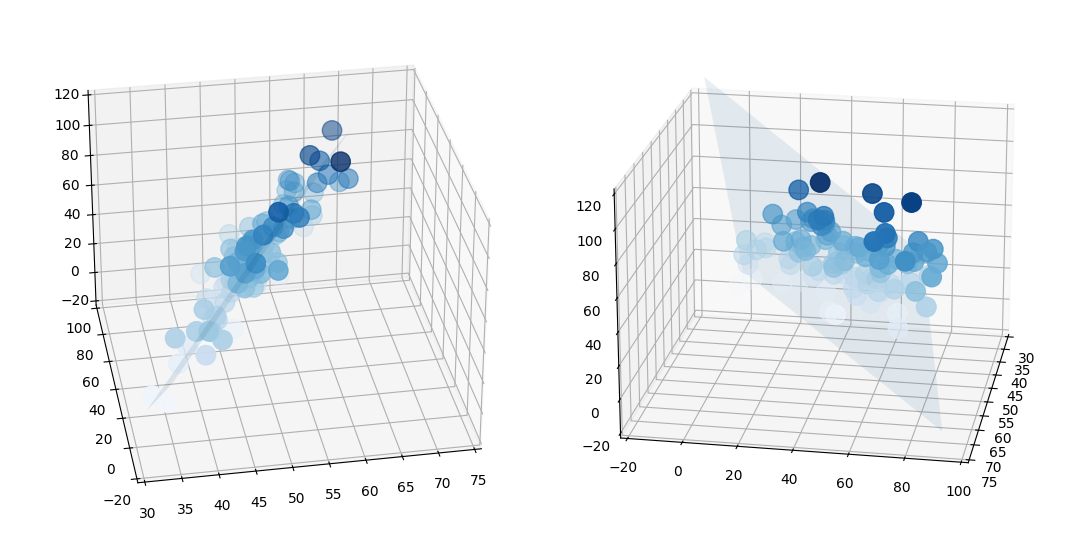

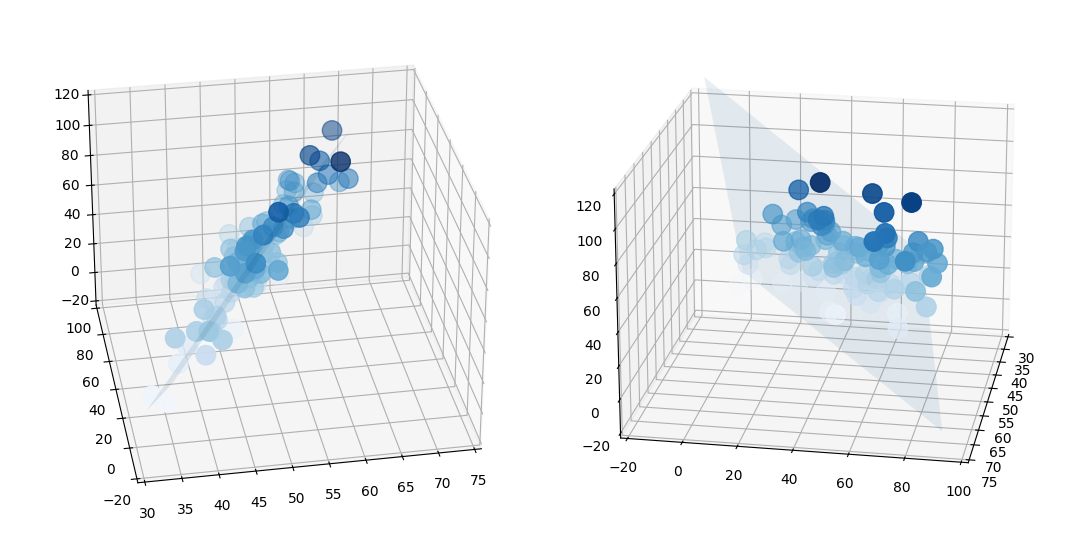

In [15]:
m = 100
mu = np.array([50, 50, 50])
r1_2 = 0.9
r1_3 = 0.7
r2_3 = 0.1
sigma1 = 5
sigma2 = 20
sigma3 = 20
c = np.array([[sigma1 ** 2, r1_2 * sigma1 * sigma2, r1_3 * sigma1 * sigma3],
             [r1_2 * sigma1 * sigma2, sigma2 ** 2, r2_3 * sigma2 * sigma3],
             [r1_3 * sigma1 * sigma3, r2_3 * sigma2 * sigma3, sigma3 ** 2]])
np.random.seed(142)
data_threeD = np.random.multivariate_normal(mu, c, m)

norm = Normalize()
cmap = get_cmap("Blues")
clrs = cmap(np.array(norm(data_threeD[:,2])))[:,0:3]

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(121, projection='3d')
ax.azim=-100
ax.scatter(data_threeD[:,0], data_threeD[:,1], data_threeD[:,2], c=clrs, s=14**2)

xx, yy = np.meshgrid(np.arange(-15, 10, 1), np.arange(-50, 30, 1))
normal = np.array([0.96981815, -0.188338, -0.15485978])
z = (-normal[0] * xx - normal[1] * yy) * 1. / normal[2]
xx = xx + 50
yy = yy + 50
z = z + 50

ax.set_zlim((-20, 120)), ax.set_ylim((-20, 100)), ax.set_xlim((30, 75))
ax.plot_surface(xx, yy, z, alpha=.10)

ax = fig.add_subplot(122, projection='3d')
ax.azim=10
ax.elev=20
#ax.dist=8
ax.scatter(data_threeD[:,0], data_threeD[:,1], data_threeD[:,2], c=clrs, s=14**2)

ax.set_zlim((-20, 120)), ax.set_ylim((-20, 100)), ax.set_xlim((30, 75))
ax.plot_surface(xx, yy, z, alpha=.1)
plt.tight_layout()
display(fig)

In [16]:
threeD_data = sc.parallelize(data_threeD)
components_threeD, threeD_scores, eigenvalues_threeD = pca(threeD_data, 2)

print ('components_threeD: \n{0}'.format(components_threeD))
print ('\nthreeD_scores (first three): \n{0}'.format('\n'.join(map(str, threeD_scores.take(3)))))
print ('\neigenvalues_threeD: \n{0}'.format(eigenvalues_threeD))

components_threeD: 
[[ 0.23952078  0.045635  ]
 [ 0.61699931  0.76409466]
 [ 0.74962768 -0.64348799]]

threeD_scores (first three): 
[85.25798606 -8.29694407]
[89.66337911 15.73381517]
[ 75.92616872 -20.5015709 ]

eigenvalues_threeD: 
[614.46863537 349.47737219   5.85043581]


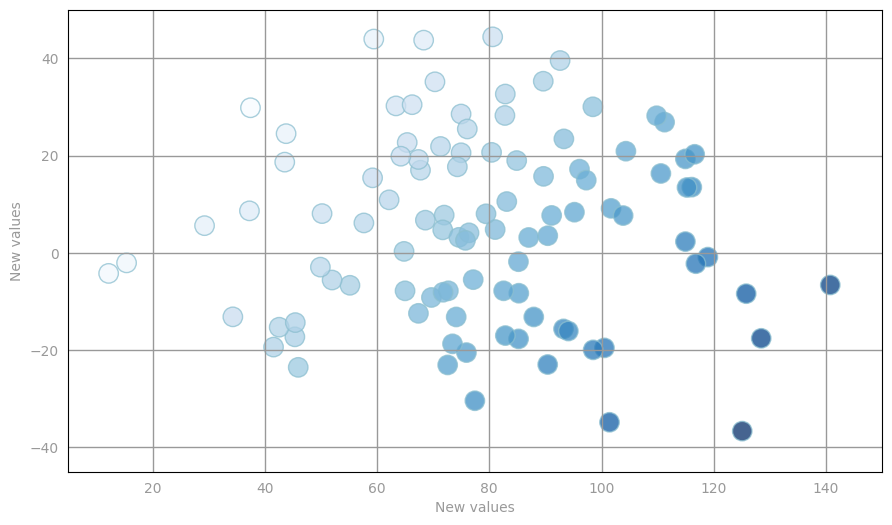

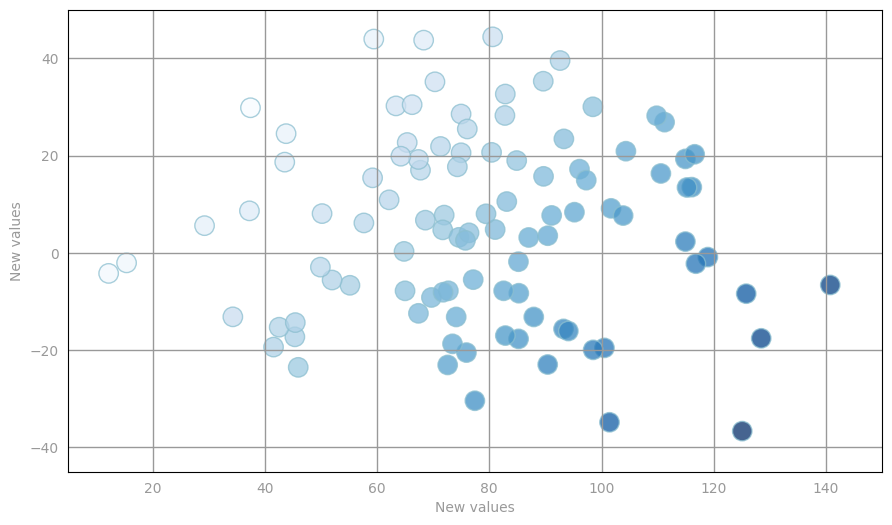

In [17]:
scores_threeD = np.asarray(threeD_scores.collect())

fig, ax = prepare_plot(np.arange(20, 150, 20), np.arange(-40, 110, 20))
ax.set_xlabel(r'New values'), ax.set_ylabel(r'New values')
ax.set_xlim(5, 150), ax.set_ylim(-45, 50)
plt.scatter(scores_threeD[:, 0], scores_threeD[:, 1], s=14 ** 2, c=clrs, edgecolors='#8cbfd0', alpha=0.75)
display(fig)

In [18]:
def variance_explained(data, k=1):
    """Calculate the fraction of variance explained by the top `k` eigenvectors.

    Args:
        data (RDD of np.ndarray): An RDD that contains NumPy arrays which store the
            features for an observation.
        k: The number of principal components to consider.

    Returns:
        float: A number between 0 and 1 representing the percentage of variance explained
            by the top `k` eigenvectors.
    """

    components, scores, eigenvalues = pca(data, k)
    retained_variance =  sum(eigenvalues[:k])/(np.sum(eigenvalues))
    return retained_variance

variance_random_1 = variance_explained(random_data_rdd, 1)
variance_correlated_1 = variance_explained(correlated_data, 1)
variance_random_2 = variance_explained(random_data_rdd, 2)
variance_correlated_2 = variance_explained(correlated_data, 2)
variance_threeD_2 = variance_explained(threeD_data, 2)
print ('Percentage of variance explained by the first component of random_data_rdd: {0:.1f}%'.format(variance_random_1 * 100))
print ('Percentage of variance explained by both components of random_data_rdd: {0:.1f}%'.format(variance_random_2 * 100))
print ('\nPercentage of variance explained by the first component of correlated_data: {0:.1f}%'.format(variance_correlated_1 * 100))
print ('Percentage of variance explained by both components of correlated_data: {0:.1f}%'.format(variance_correlated_2 * 100))
print ('\nPercentage of variance explained by the first two components of threeD_data: {0:.1f}%'.format(variance_threeD_2 * 100))

Percentage of variance explained by the first component of random_data_rdd: 58.8%
Percentage of variance explained by both components of random_data_rdd: 100.0%

Percentage of variance explained by the first component of correlated_data: 93.4%
Percentage of variance explained by both components of correlated_data: 100.0%

Percentage of variance explained by the first two components of threeD_data: 99.4%
